#HW2

In [61]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import graphviz 
from mpl_toolkits.mplot3d import Axes3D
!pip install plotly_express
import plotly_express as px
from sklearn import svm
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import math

## Loading the dataset

In [120]:
# !rm *.csv

# from google.colab import files
# print("Please load the raw csv data")
# uploadedData = files.upload()
# filename = list(uploadedData)[0]

In [62]:
url_train='https://raw.githubusercontent.com/eladaspis/ML_Wet2/main/train.csv?token=AC7326L5UTT7KAOU4YFFO2LAYN6EK'
url_val='https://raw.githubusercontent.com/eladaspis/ML_Wet2/main/validation.csv?token=AC7326PFN34IFHV7F43OHJDAYN6GC'
url_test='https://raw.githubusercontent.com/eladaspis/ML_Wet2/main/test.csv?token=AC7326J6HT6FPFH4OAR4S73AYN6HK'
url_real_test = 'https://raw.githubusercontent.com/eladaspis/ML_Wet2/main/virus_test.csv?token=AC7326KCDBDV7B7RKVJUXPDAYN6IU'

train = pd.read_csv(url_train)
val=pd.read_csv(url_val)
test=pd.read_csv(url_test)
real_test=pd.read_csv(url_real_test)
train = train.drop(['AgeGroup', 
       'HouseholdExpenseParkingTicketsPerYear', 'NrCousins', 
       'PCR_32', 'PCR_45', 'PCR_46', 'PCR_83','SocialActivitiesPerDay',
       'StepsPerYear', 'StudingPerDay'], axis=1)
# print(train.columns)
val = val.drop(['AgeGroup', 
       'HouseholdExpenseParkingTicketsPerYear', 'NrCousins', 
       'PCR_32', 'PCR_45', 'PCR_46', 'PCR_83','SocialActivitiesPerDay',
       'StepsPerYear', 'StudingPerDay'], axis=1)
test = test.drop(['AgeGroup', 
       'HouseholdExpenseParkingTicketsPerYear', 'NrCousins', 
       'PCR_32', 'PCR_45', 'PCR_46', 'PCR_83','SocialActivitiesPerDay',
       'StepsPerYear', 'StudingPerDay'], axis=1)
print(train.columns)
train=train.fillna("")
val=val.fillna("")
test=test.fillna("")


train_ID = train.ID.copy()
train = train.drop(['ID'], axis=1)
X_train = train.drop(['Virus', 'SpreadLevel','Risk'], axis=1)
y_train = train[['Virus', 'SpreadLevel','Risk']]

val_ID = val.ID.copy()
val = val.drop(['ID'], axis=1)
X_val = val.drop(['Virus', 'SpreadLevel','Risk'], axis=1)
y_val = val[['Virus', 'SpreadLevel','Risk']]


test_ID = test.ID.copy()
test = test.drop(['ID'], axis=1)
X_test = test.drop(['Virus', 'SpreadLevel','Risk'], axis=1)
y_test = test[['Virus', 'SpreadLevel','Risk']]

real_test_ID = real_test.ID.copy()
X_real_test = real_test.drop(['ID'], axis=1)

Index(['ID', 'BMI', 'ConversatiosPerDay', 'DisciplineScore', 'HappinessScore',
       'HouseholdExpenseOnPresents', 'HouseholdExpenseOnSocialGames', 'PCR_10',
       'PCR_17', 'PCR_19', 'PCR_7', 'PCR_72', 'PCR_76', 'PCR_8', 'PCR_89',
       'PCR_9', 'PCR_93', 'PCR_95', 'SocialMediaPerDay', 'Virus',
       'SpreadLevel', 'Risk'],
      dtype='object')


In [122]:
# #shuffle and split the data
# X_train, X_temp, y_train, y_temp = train_test_split(X_train, y[label], test_size=0.4, random_state=11)
# X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=11)
# def remove_empty_rows(X,y):
#  for label in y.columns: 
#    for index in range(len(X)):
#      if y[label] is "":
#           print(X[index])
#        X = X.drop(index)
#        print("removed")

In [3]:
#model training
#inputs: X_train,y_train,X_val,y_val, model, hyper_par range(1,101)
#outputs: train accuracy array, train loss arr, val accuracy arr, val loss arr
def model_infer(X_train,y_train,X_val,y_val,model,h_range):
  num_of_lables=y_train.shape[1]
  accuracy_train =[[] for i in range(num_of_lables)]
  accuracy_validation = [[] for i in range(num_of_lables)]
  count=0
  for label in y_train:
      for k in h_range:
        if model is LinearSVC:
          clf = LinearSVC(C=k,dual = True).fit(X_train,y_train[label]) 
        elif model is DecisionTreeClassifier:
          clf = model(criterion='entropy',max_depth=k).fit(X_train,y_train[label]) 
        else: 
          clf = model(k).fit(X_train,y_train[label]) 
        y_train_predicted = clf.predict(X_train)
        y_validation_predicted = clf.predict(X_val)
        accuracy_train[count].append(metrics.accuracy_score(y_train[label], y_train_predicted))
        accuracy_validation[count].append(metrics.accuracy_score(y_val[label], y_validation_predicted))
      count+=1
  return accuracy_train,accuracy_validation


In [63]:
#normalization for data
def normalize_data(df):
  for label in df.columns:
    df[label] = stats.zscore(df[label])
  
def remove_outlier_Indices(X,y):
  X = X.copy()
  y = y.copy()
  for label in X.columns:
    Q1 = X[label].quantile(0.1)
    Q3 = X[label].quantile(0.9)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    index = (X[label] < upper_limit) & (X[label] > lower_limit)
    X = X[index]
    y = y[index]
  return X,y

In [5]:
#make plots
def make_plots(accuracy_array,title,xlabel,ylabel,rg):
  plt.figure(figsize=(10,6))
  for index in range(len(accuracy_array)):  
    plt.plot(rg,accuracy_array[index])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid()
  print("Maximum accuracy:-",max(accuracy_array[0]),"at K =",rg[accuracy_array[0].index(max(accuracy_array[0]))])
  print("Maximum accuracy:-",max(accuracy_array[1]),"at K =",rg[accuracy_array[1].index(max(accuracy_array[1]))])
  print("Maximum accuracy:-",max(accuracy_array[2]),"at K =",rg[accuracy_array[2].index(max(accuracy_array[2]))])
  plt.legend(['Virus', 'SpreadLevel','Risk'])


In [64]:
#normalized data

normalize_data(X_train)
X_train,y_train = remove_outlier_Indices(X_train,y_train)
print(X_train.shape)
normalize_data(X_val)
X_val,y_val = remove_outlier_Indices(X_val,y_val)
normalize_data(X_test)

(1645, 18)


# KNN

Maximum accuracy:- 1.0 at K = 1
Maximum accuracy:- 1.0 at K = 1
Maximum accuracy:- 1.0 at K = 1
Maximum accuracy:- 0.7427007299270073 at K = 15
Maximum accuracy:- 0.6204379562043796 at K = 49
Maximum accuracy:- 0.708029197080292 at K = 13


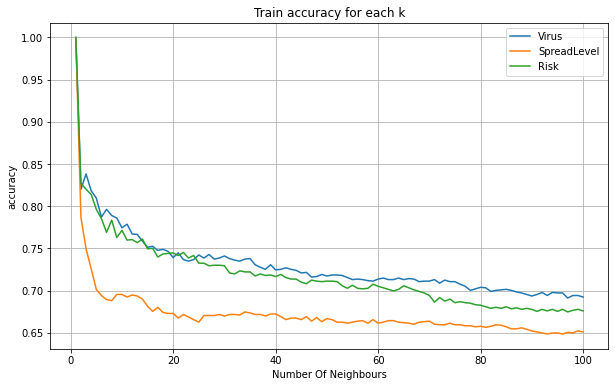

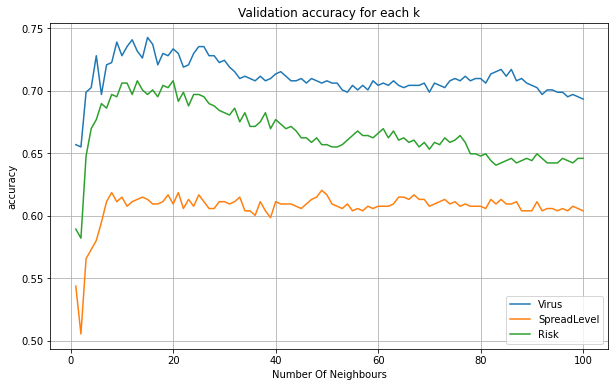

In [127]:
#main model infer
rg = range(1,101)
train_acc_arr_knn, val_acc_arr_knn = model_infer(X_train, y_train, X_val, y_val ,KNeighborsClassifier,rg)

# main model plot
make_plots(train_acc_arr_knn,'Train accuracy for each k','Number Of Neighbours','accuracy',rg)
make_plots(val_acc_arr_knn,'Validation accuracy for each k','Number Of Neighbours','accuracy',rg)

Tune K Param

In [7]:
#Choose the best param for KNN
val_acc_arr_knn = [15,11,8]

# Decision Trees

Maximum accuracy:- 1.0 at K = 26
Maximum accuracy:- 1.0 at K = 16
Maximum accuracy:- 1.0 at K = 15
Maximum accuracy:- 0.6806569343065694 at K = 10
Maximum accuracy:- 0.8485401459854015 at K = 30
Maximum accuracy:- 0.8065693430656934 at K = 5


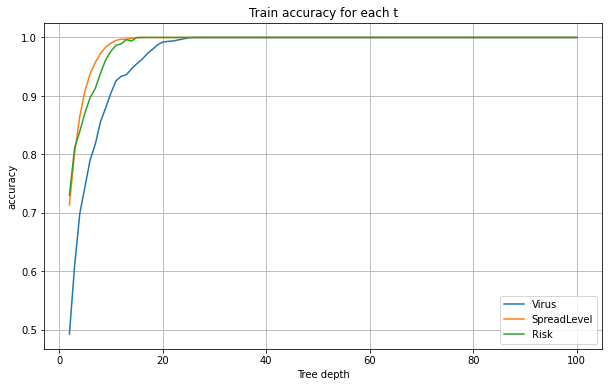

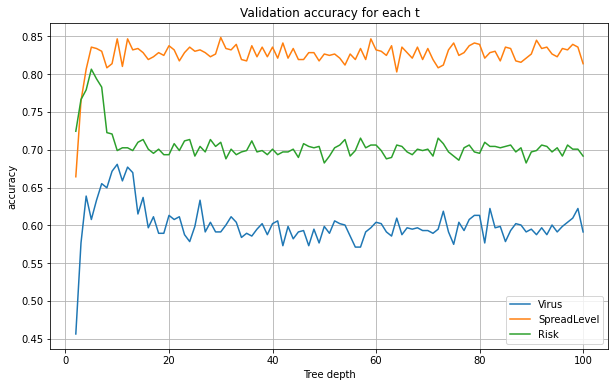

In [129]:
# #main model infer
rg = range(2,101)
train_acc_arr_dt,val_acc_arr_dt=model_infer(X_train, y_train, X_val, y_val ,DecisionTreeClassifier,rg)
#Q6 main model plot
make_plots(train_acc_arr_dt,  'Train accuracy for each t','Tree depth','accuracy',rg)
make_plots(val_acc_arr_dt, 'Validation accuracy for each t','Tree depth','accuracy',rg)

In [25]:
#Choose the best param for DT
# val_acc_arr_dt = [10,5,5]
val_acc_arr_dt = [11,5,5]

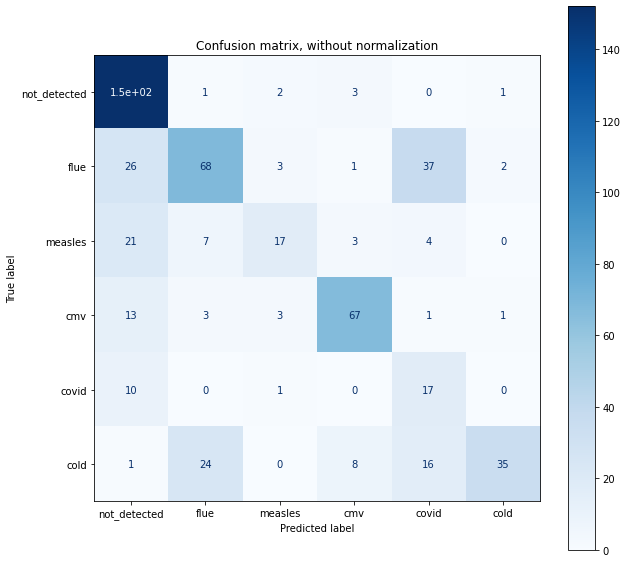

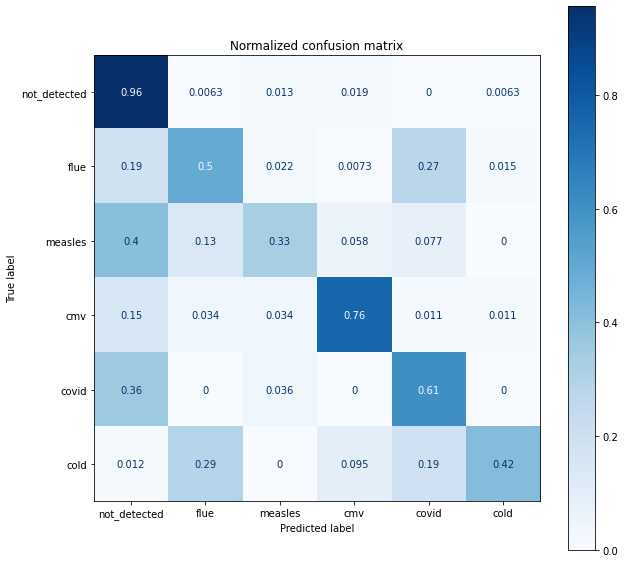

In [131]:
#Q8
optimal_depth=val_acc_arr_dt[0]
clf = DecisionTreeClassifier(criterion='entropy',max_depth=optimal_depth).fit(X_train,y_train['Virus'])
y_val_pred = clf.predict(X_val)

#print confusion matrix
confusion_matrix(y_val['Virus'], y_val_pred, labels=y_val['Virus'].unique())

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
  fig, ax = plt.subplots(figsize=(10, 10))
  disp = plot_confusion_matrix(clf, X_val, y_val['Virus'],
                                 display_labels=y_val['Virus'].unique(),    cmap=plt.cm.Blues,normalize=normalize, ax=ax)
  disp.ax_.set_title(title)
plt.show()

# mat = confusion_matrix(ytest, yfit)
# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=faces.target_names,
#             yticklabels=faces.target_names)
# plt.xlabel('true label')
# plt.ylabel('predicted label');


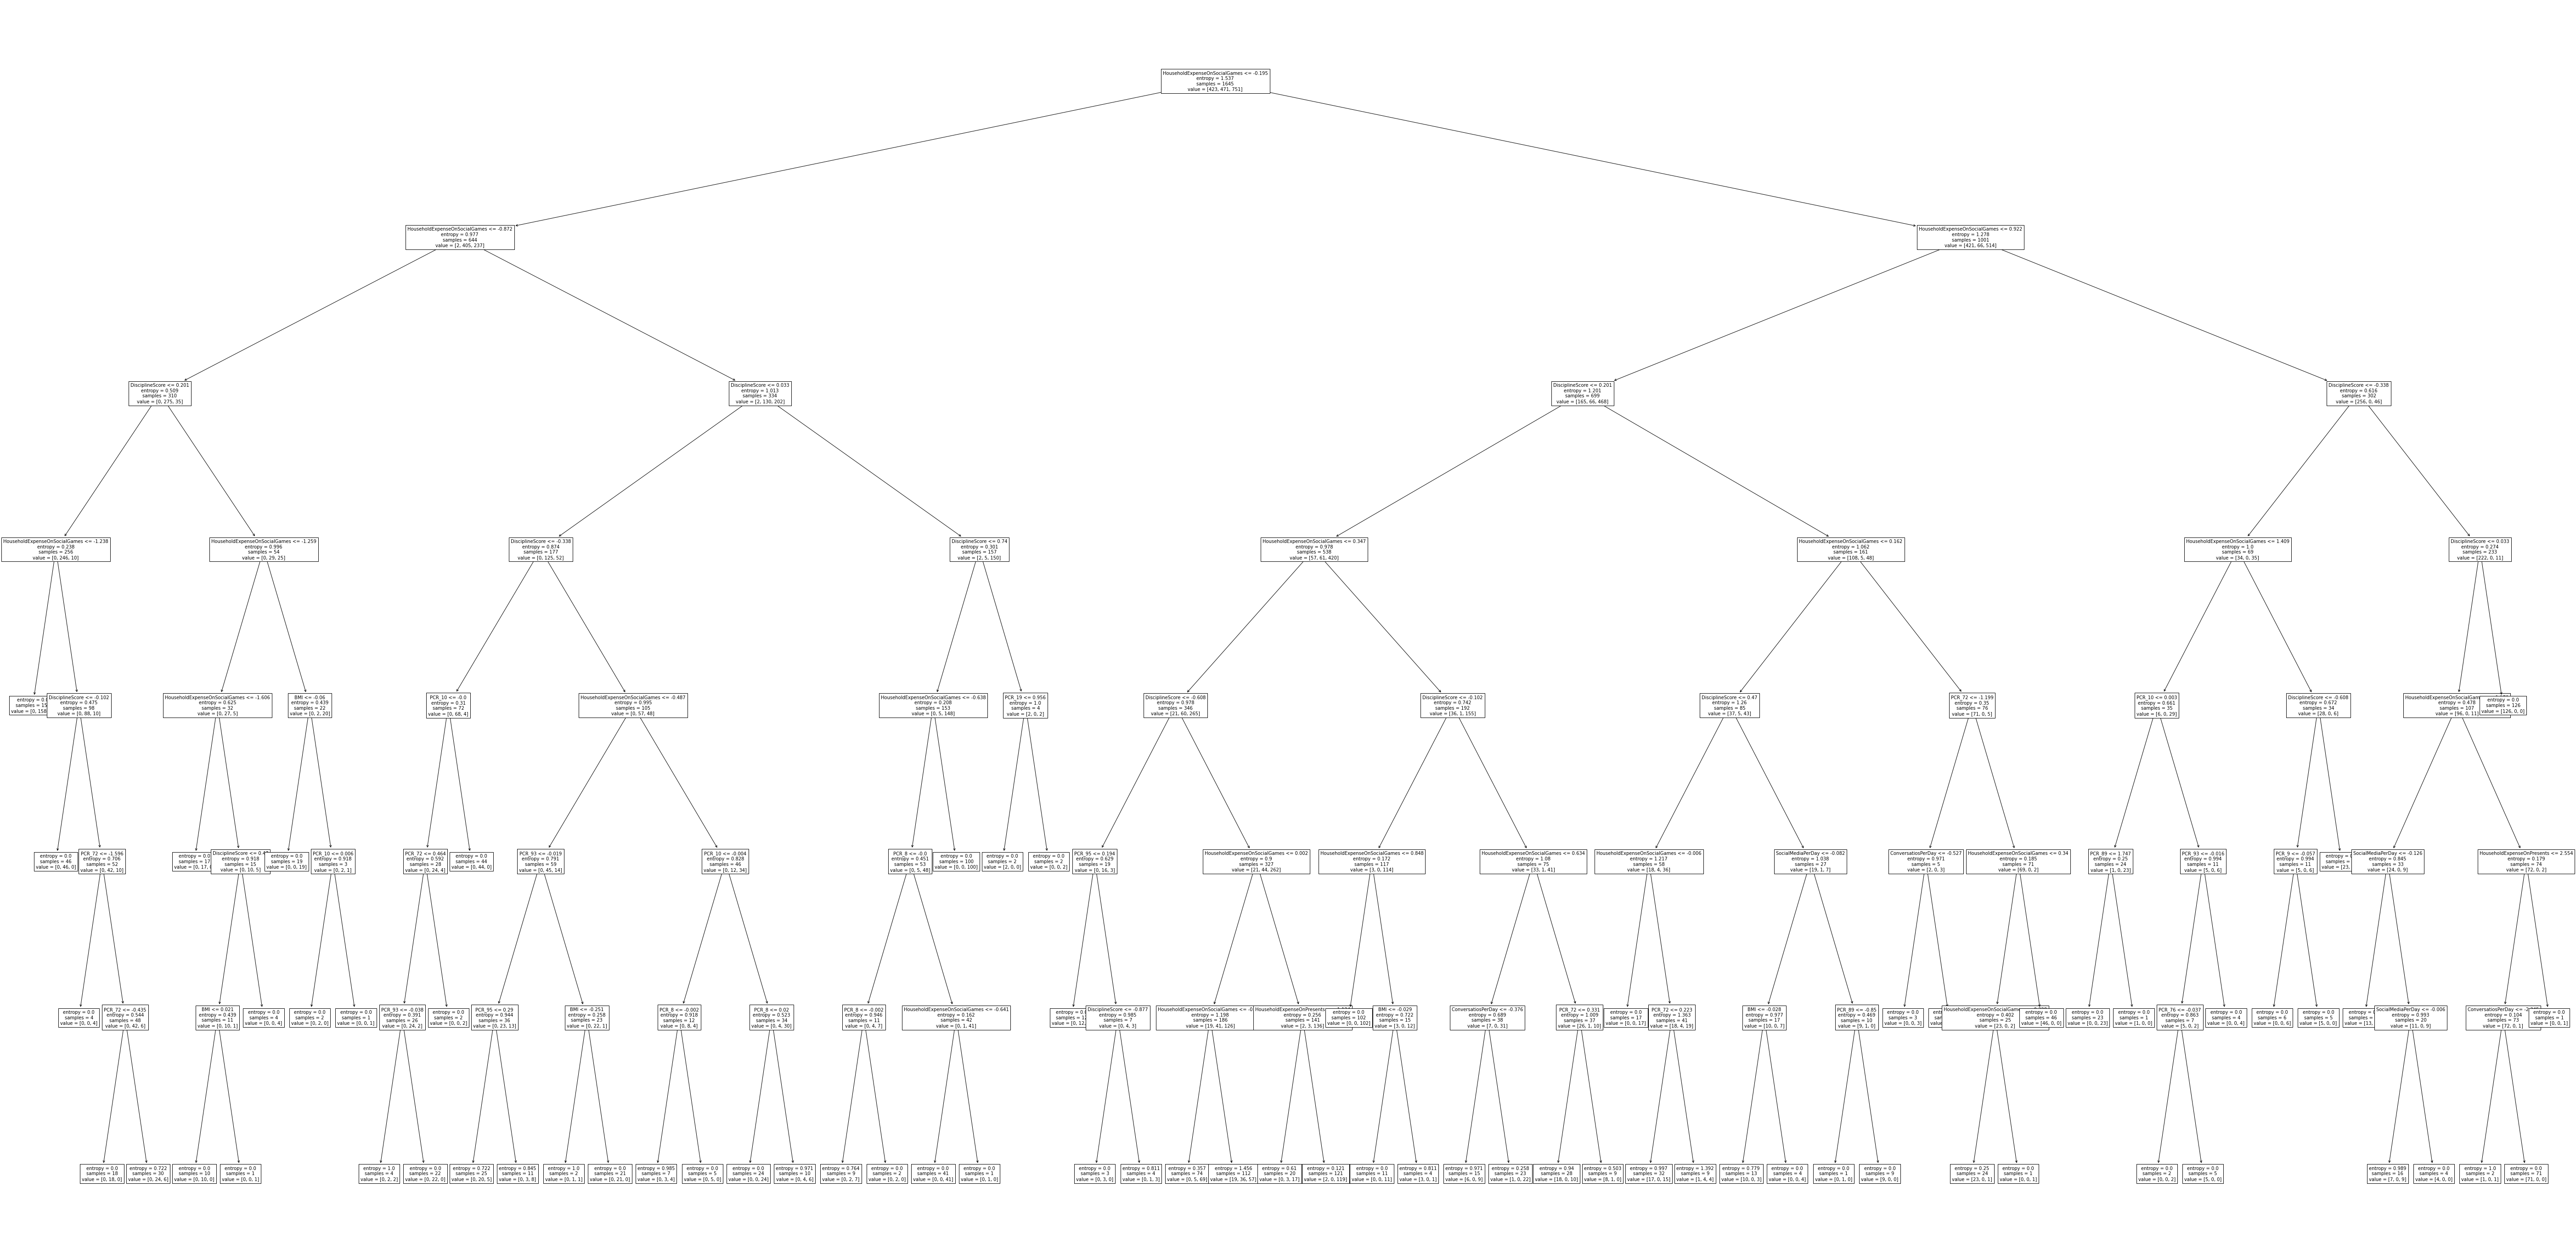

In [150]:
#Q9 Plot the decision tree
test_depth=7
clf = DecisionTreeClassifier(criterion='entropy',max_depth=test_depth).fit(X_train,y_train['Risk'])
y_val_pred = clf.predict(X_val)
plt.figure(figsize=(100,50))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=10, feature_names=X_train.columns)
plt.show()

score: 0.896048632218845


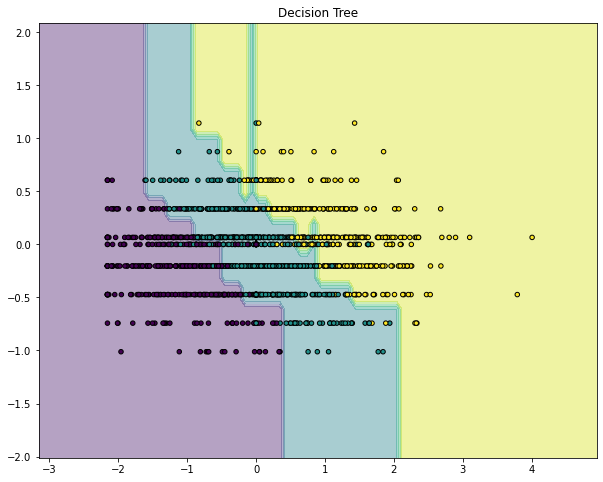

score: 0.8941605839416058


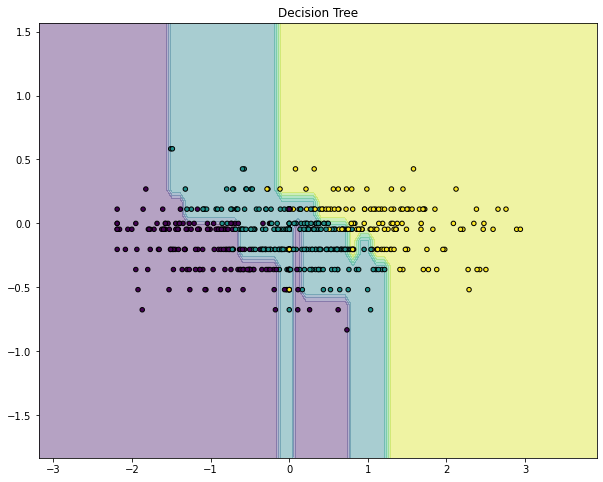

In [165]:
#Q10 Plot the decision boundaries
def decision_boundaries(X,y, features):
  clf = DecisionTreeClassifier(criterion='entropy',max_depth=7)
  clf.fit(X,y)
  # print(X[features[0]].min())
  # print(X[features[0]].max())
  # print(X[features[1]].min())
  # print(X[features[1]].max())

  x_min, x_max = X[features[0]].min() - 1, X[features[0]].max() + 1
  y_min, y_max = X[features[1]].min() - 1, X[features[1]].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                       np.arange(y_min, y_max, 0.1))
  f, axarr = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  print("score:" , clf.score(X,y))
  axarr.contourf(xx, yy, Z, alpha=0.4)
  axarr.scatter(X[features[0]], X[features[1]], c=y,
                s=20, edgecolor='k')
  axarr.set_title('Decision Tree')
  plt.show()

convert_dict = {'low': 1, 'medium': 2, 'high':3 }
y_train_risk_converted = y_train.Risk.apply(lambda r: convert_dict[r])
y_val_risk_converted = y_val.Risk.apply(lambda r: convert_dict[r])

best_features = ['HouseholdExpenseOnSocialGames','DisciplineScore']
decision_boundaries(X_train[best_features],y_train_risk_converted, best_features)
decision_boundaries(X_val[best_features],y_val_risk_converted, best_features)

5


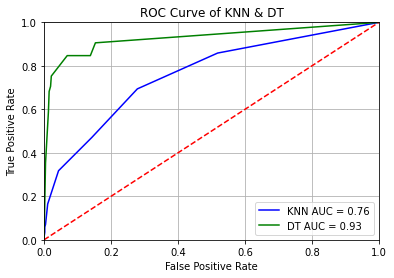

In [14]:
#Q11 ROC tested on validation set Knn and decision tree
best_k=val_acc_arr_knn[1]
knn = KNeighborsClassifier(n_neighbors = best_k)

#train numeric convertion label
y_train_temp=y_train['SpreadLevel'].copy()
y_t = pd.Series([1 if item == 'high' else 0 for item in y_train_temp])

y_t=y_t.astype(bool)
knn.fit(X_train,y_t)

#validation to bool
y_val_temp=y_val['SpreadLevel'].copy()
y_v=pd.Series([1 if item == 'high' else 0 for item in y_val_temp])


y_v=y_v.astype(bool)
#print(len(y_v))

# test_depth = val_acc_arr_dt[1].index(max(val_acc_arr_dt[1]))+2
test_depth = val_acc_arr_dt[1]
print(test_depth)

#TREE
tree2 = DecisionTreeClassifier(criterion="entropy",max_depth=test_depth).fit(X_train,y_t)
y_scores2 = tree2.predict_proba(X_val)

#KNN
y_scores = knn.predict_proba(X_val)

fpr, tpr, threshold = roc_curve(y_v, y_scores[:, 1])
fpr2, tpr2, threshold2 = roc_curve(y_v, y_scores2[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'KNN AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'DT AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of KNN & DT')
plt.grid()
plt.show()

# SVM

Maximum accuracy:- 0.6389057750759879 at K = 20.21
Maximum accuracy:- 0.8656534954407294 at K = 17.180000000000003
Maximum accuracy:- 0.8680851063829788 at K = 14.15
Maximum accuracy:- 0.6386861313868614 at K = 2.03
Maximum accuracy:- 0.8047445255474452 at K = 3.04
Maximum accuracy:- 0.8047445255474452 at K = 1.02


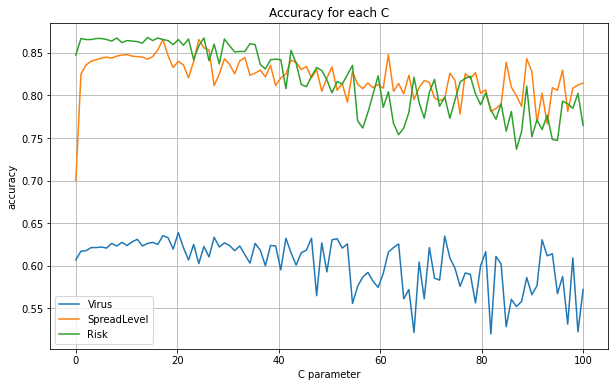

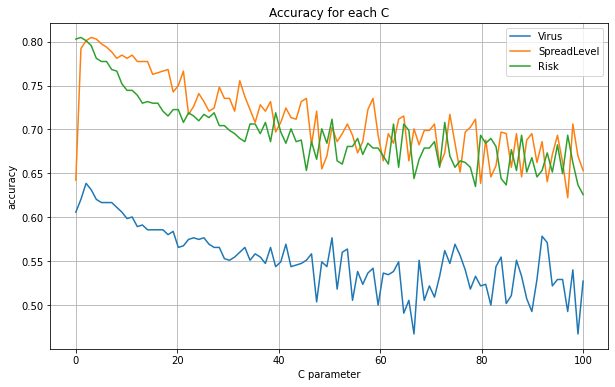

In [159]:
#main model infer
# rg = np.logspace(-3,3,num=20)
# train_acc_arr_svm,val_acc_arr_svm=model_infer(X_train, y_train, X_val, y_val ,LinearSVC,rg)

# #main model plot
# make_plots(train_acc_arr_svm,'Accuracy for each C','C parameter','accuracy',rg)
# make_plots(val_acc_arr_svm,'Accuracy for each C','C parameter','accuracy',rg)

rg = np.linspace(0.01,100,num=100)

train_acc_arr_svm,val_acc_arr_svm=model_infer(X_train, y_train, X_val, y_val ,LinearSVC,rg)
#main model plot
make_plots(train_acc_arr_svm,'Accuracy for each C','C parameter','accuracy',rg)
make_plots(val_acc_arr_svm,'Accuracy for each C','C parameter','accuracy',rg)

In [9]:
#Choose the best param for SVM
val_acc_arr_svm = [2.03,3.04,1.02]

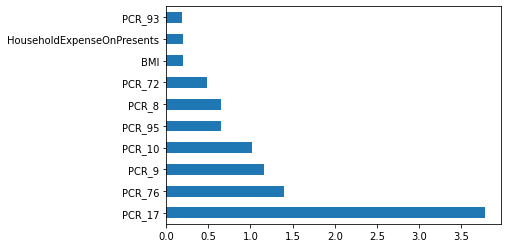

In [171]:
#Q15
best_C=val_acc_arr_svm[0]
clf = LinearSVC(C=best_C,dual = True).fit(X_train,y_train['Virus'])
flu_index=np.where(clf.classes_=='flue')[0][0]
index = enumerate(X_train.columns)
pd.Series(abs(clf.coef_[flu_index]), X_train.columns).nlargest(10).plot(kind='barh')

In [40]:
#q17
rows_list = ["KNN", "DT", "SVM"]
# rows_list = ["KNN", "DT"]
columns_list = ['Virus', 'SpreadLevel','Risk']
test_accuracies = [[] for i in range(3)]
best_values = [[] for i in range(3)]
#KNN
rg = range(1,101)
# best_values[0].append(rg[val_acc_arr_knn[0].index(max(val_acc_arr_knn[0]))])
best_values[0].append(val_acc_arr_knn[0])
best_values[0].append(val_acc_arr_knn[1])
best_values[0].append(val_acc_arr_knn[2])


for k,label in zip(best_values[0],y_train.columns):
  clf = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train[label]) 
  test_accuracies[0].append(clf.score(X_test,y_test[label]))

rg = range(2,101)
best_values[1].append(val_acc_arr_dt[0])
best_values[1].append(val_acc_arr_dt[1])
best_values[1].append(val_acc_arr_dt[2])


for depth,label in zip(best_values[1],y_train.columns):
  clf = DecisionTreeClassifier(criterion='entropy', max_depth=k).fit(X_train,y_train[label]) 
  test_accuracies[1].append(clf.score(X_test,y_test[label]))

rg = np.linspace(0.01,50,num=100)
best_values[2].append(val_acc_arr_svm[0])
best_values[2].append(val_acc_arr_svm[1])
best_values[2].append(val_acc_arr_svm[2])


print(best_values)
for C_value,label in zip(best_values[2],y_train.columns):
  clf = LinearSVC(C=C_value,dual = True).fit(X_train,y_train[label]) 
  test_accuracies[2].append(clf.score(X_test,y_test[label]))

pd.DataFrame(test_accuracies, rows_list, columns_list)


[[15, 11, 8], [11, 5, 5], [2.03, 3.04, 1.02]]


,Virus,SpreadLevel,Risk
KNN,0.728333,0.635000,0.696667
DT,0.591667,0.548333,0.735000
SVM,0.546667,0.508333,0.723333


# Part 5

In [65]:
# train_sub = train.copy()
# for index, row in train_sub.iterrows():
#   if row['Virus'] !='covid' and row['Virus'] !='cmv':
#     train_sub.drop(index, inplace=True)

# val_sub = val.copy()
# for index, row in val_sub.iterrows():
#   if row['Virus'] !='covid' and row['Virus'] !='cmv':
#     val_sub.drop(index, inplace=True)

train_sub = train.copy()
for index, row in train_sub.iterrows():
  if row['Virus'] !='covid' and row['Virus'] !='cmv':
    train_sub.drop(index, inplace=True)

val_sub = val.copy()
for index, row in val_sub.iterrows():
  if row['Virus'] !='covid' and row['Virus'] !='cmv':
    val_sub.drop(index, inplace=True)

color_dict = {'covid': 'red', 'cmv':'blue'}

px.scatter_3d(train_sub, x="PCR_7", y="PCR_72", z="PCR_89",
              color='Virus', color_discrete_map = color_dict)

In [66]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
X_train_sub = train_sub.drop(['Virus', 'SpreadLevel','Risk'], axis=1)
normalize_data(X_train_sub)
y_train_sub = train_sub.Virus
X_val_sub = val_sub.drop(['Virus', 'SpreadLevel','Risk'], axis=1)
normalize_data(X_val_sub)
y_val_sub = val_sub.Virus


In [59]:
#polynom iteration:
for i in range(2,20):
  svclassifier = SVC(kernel='poly', degree=8)
  svclassifier.fit(X_train_sub, y_train_sub)
  y_pred = svclassifier.predict(X_val_sub)
  print(classification_report(y_val_sub,y_pred))

y_pred_train = svclassifier.predict(X_train_sub)
print(classification_report(y_train_sub,y_pred_train))

#polynom
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_train_sub, y_train_sub)
y_pred = svclassifier.predict(X_val_sub)
print(classification_report(y_val_sub,y_pred))

y_pred_train = svclassifier.predict(X_train_sub)
print(classification_report(y_train_sub,y_pred_train))


#rbf
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train_sub, y_train_sub)
y_pred = svclassifier.predict(X_val_sub)
print(classification_report(y_val_sub,y_pred))

y_pred_train = svclassifier.predict(X_train_sub)
print(classification_report(y_train_sub,y_pred_train))


              precision    recall  f1-score   support

         cmv       0.75      0.98      0.85       174
       covid       0.00      0.00      0.00        57

    accuracy                           0.74       231
   macro avg       0.38      0.49      0.43       231
weighted avg       0.56      0.74      0.64       231

              precision    recall  f1-score   support

         cmv       0.75      0.98      0.85       174
       covid       0.00      0.00      0.00        57

    accuracy                           0.74       231
   macro avg       0.38      0.49      0.43       231
weighted avg       0.56      0.74      0.64       231

              precision    recall  f1-score   support

         cmv       0.75      0.98      0.85       174
       covid       0.00      0.00      0.00        57

    accuracy                           0.74       231
   macro avg       0.38      0.49      0.43       231
weighted avg       0.56      0.74      0.64       231

              preci

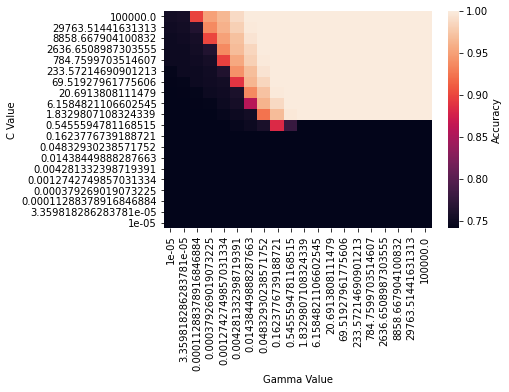

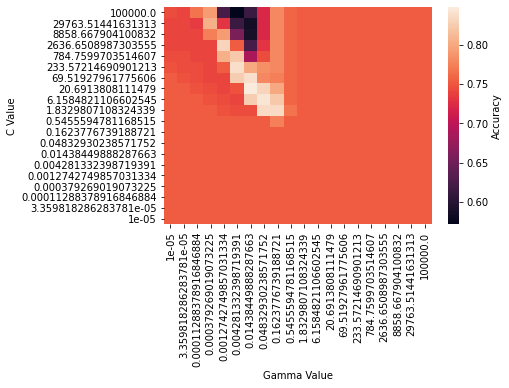

In [79]:
C_2d_range = np.logspace(-5,5,num=20)
gamma_2d_range = np.logspace(-5,5,num=20)
classifiers_train, classifiers_val = [], []
tmp = [0,0,-1]
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_train_sub, y_train_sub)
        classifiers_train.append((C, gamma, clf.score(X_train_sub, y_train_sub)))
        classifiers_val.append((C, gamma, clf.score(X_val_sub,y_val_sub)))
        if  clf.score(X_val_sub,y_val_sub) > tmp[2] and clf.score(X_train_sub, y_train_sub) == 1:
          tmp[0] = C
          tmp[1] = gamma
          tmp[2] = clf.score(X_val_sub,y_val_sub)

df = pd.DataFrame(data=classifiers_train, columns = ['C Value','Gamma Value','Accuracy'])
table = df.pivot('C Value','Gamma Value','Accuracy')
ax = sns.heatmap(table, cbar_kws={'label': 'Accuracy'})
ax.invert_yaxis()
plt.show()

df = pd.DataFrame(data=classifiers_val, columns = ['C Value','Gamma Value','Accuracy'])
table = df.pivot('C Value','Gamma Value','Accuracy')
ax = sns.heatmap(table, cbar_kws={'label': 'Accuracy'})
ax.invert_yaxis()
plt.show()

In [80]:
max(classifiers_val)
max(classifiers_train)
print(tmp)
clf = SVC(C=tmp[0], gamma=tmp[1])
clf.fit(X_train_sub, y_train_sub)
print(clf.score(X_train_sub,y_train_sub))

[233.57214690901213, 0.1623776739188721, 0.7792207792207793]
1.0


# Edit test_virus.csv - removing features

In [82]:
from scipy.stats import zscore
to_convert=['Sex', 'BloodType','Job']
X_real_test[to_convert] = X_real_test[to_convert].astype('category')
X_real_test = X_real_test.drop(columns=['Job','PCR_11','PCR_15','Address','DateOfPCRTest','CurrentLocation','Self_declaration_of_Illness_Form','Sex','BloodType','SportsPerDay','MedicalCarePerYear',
        'AgeGroup', 'HouseholdExpenseParkingTicketsPerYear', 'NrCousins', 
       'PCR_32', 'PCR_45', 'PCR_46', 'PCR_83','SocialActivitiesPerDay', 'StepsPerYear', 'StudingPerDay'])
X_real_test = X_real_test.apply(pd.to_numeric, errors='ignore')
print(X_real_test.columns)

for label in X_real_test.columns:
  temp = []
  for val in X_real_test[label]:
    if math.isnan(float(val)):
      temp.append(np.nanmean(X_real_test[label]))
    else:
      temp.append(val)
  X_real_test[label] = temp
normalize_data(X_real_test)

Index(['BMI', 'ConversatiosPerDay', 'DisciplineScore', 'HappinessScore',
       'HouseholdExpenseOnPresents', 'HouseholdExpenseOnSocialGames', 'PCR_10',
       'PCR_17', 'PCR_19', 'PCR_7', 'PCR_72', 'PCR_76', 'PCR_8', 'PCR_89',
       'PCR_9', 'PCR_93', 'PCR_95', 'SocialMediaPerDay'],
      dtype='object')


Part 7 - Submitted model predictions

In [83]:
from google.colab import files

outputPath= 'pred_knn.csv'
df = pd.DataFrame()
for index, label in enumerate(y_train.columns):
  best_k_knn = best_values[0][index]
  clf = KNeighborsClassifier(n_neighbors=best_k_knn).fit(X_train,y_train[label]) 
  predictions = clf.predict(X_real_test)
  df.insert(index, label, predictions, True)
df.insert(0, 'ID', real_test_ID, True)
df.to_csv(outputPath, index=False)
files.download(outputPath) 

outputPath= 'pred_dt.csv'
df = pd.DataFrame()
for index, label in enumerate(y_train.columns):
  best_depth = best_values[1][index]
  clf = DecisionTreeClassifier(criterion="entropy",max_depth=best_depth).fit(X_train,y_train[label]) 
  predictions = clf.predict(X_real_test)
  df.insert(index, label, predictions, True)
df.insert(0, 'ID', real_test_ID, True)
df.to_csv(outputPath, index=False)
files.download(outputPath) 


outputPath= 'pred_svm.csv'
df = pd.DataFrame()
for index, label in enumerate(y_train.columns):
  best_c = best_values[2][index]
  clf = LinearSVC(C=best_c,dual = True).fit(X_train,y_train[label]) 
  predictions = clf.predict(X_real_test)
  df.insert(index, label, predictions, True)
df.insert(0, 'ID', real_test_ID, True)
df.to_csv(outputPath, index=False)
files.download(outputPath) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>